<h1><center>Spaceship Titanic Prediction - Supervised Learning</center></h1>
<center>October 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction   
    1. Notebook Preparation
    1. Dataset
1. Initial Data Cleaning
    1. Duplicate rows
    1. Datatypes
    1. Missing values
1. EDA
    1. Distribution
    1. Distribution according to target label
    1. Missing Values
    1. Values
1. Data Formatting
1. Preprocessing
    1. Transformations
    1. Data Splitting
1. Models
    1. Basic model
    1. Baseline model
    1. Hyperparameter Tuning
    1. Best model on test data
    1. Model Interpretation 
1. Deploy the model
1. Improvements

# 1. Project Introduction

## 1.1. Notebook Preparation

In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eda import *
from utils.model import *

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_validate, GridSearchCV)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, FunctionTransformer,
                                   StandardScaler)
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             precision_score, recall_score, make_scorer)
import graphviz
import shap
import pickle
from fastapi import FastAPI

## 1.2. Dataset

Objective: Brief overview of our dataset, including the features and target 
variable

The dataset was downloaded from Kaggle, [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/data?select=train.csv)
, on 18 October 2024. <br>
This dataset is part of an open Kaggle competition, 
where the task is to predict whether a passenger was transported to an 
alternate dimension during the Spaceship Titanic's collision with the 
spacetime anomaly. <br>
The data originally comes in 2 separate datasets, *train.csv* and *test.csv*
. Each dataset contains a set of personal records recovered from the ship's
 damaged computer system. There are 13 columns of personal records, and the 
 14th column is the target.

- train.csv - Personal records for about two-thirds (~8700) of the 
passengers, to be used as training data.
- test.csv - Personal records for the remaining one-third (~4300) of the 
passengers, to be used as test data. Does not include the target variable. 
My task is to predict the value of Transported for the passengers in this set.
<ol>
<li>PassengerId - A unique Id for each passenger. Each Id takes the form 
gggg_pp where gggg indicates a group the passenger is travelling with and pp
 is their number within the group. People in a group are often family 
 members, but not always.</li>
<li>HomePlanet - The planet the passenger departed from, typically their planet
 of permanent residence.</li>
<li>CryoSleep - Indicates whether the passenger elected to be put into 
suspended animation for the duration of the voyage. Passengers in cryosleep 
are confined to their cabins.</li>
<li>Cabin - The cabin number where the passenger is staying. Takes the form 
deck/num/side, where side can be either P for Port or S for Starboard.</li>
<li>Destination - The planet the passenger will be debarking to.</li>
<li>Age - The age of the passenger.</li>
<li>VIP - Whether the passenger has paid for special VIP service during the 
voyage.</li>
<li>RoomService - Amount the passenger has billed at this luxury amenity. </li>
<li>FoodCourt - Amount the passenger has billed at this luxury amenity. </li>
<li>ShoppingMall - Amount the passenger has billed at this luxury amenity. </li>
<li>Spa - Amount the passenger has billed at this luxury amenity. </li>
<li>VRDeck - Amount the passenger has billed at this luxury amenity. </li>
<li>Name - The first and last names of the passenger.</li>
<li>Transported - Whether the passenger was transported to another dimension. 
This is the target, the column I am trying to predict.</li>
</ol>

In [3]:
spaceship_train = pd.read_csv('data/train.csv')
display(spaceship_train.head())
spaceship_train_shape = spaceship_train.shape
print(f"Number of rows on train data: {spaceship_train_shape[0]}\nNumber of "
      f"columns on train data: {spaceship_train_shape[1]}")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Number of rows on train data: 8693
Number of columns on train data: 14


# 2. Initial Data cleaning
Objective:
1. Closer look at the values that consist of our data
2. Look out for duplicates, and missing and/or unusual values

## 2.1. Duplicate rows

In [4]:
print(spaceship_train['PassengerId'].duplicated().any())

False


## 2.2. Datatypes

In [5]:
spaceship_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In our feature columns, there is only 'object' and 'float' datatypes, the 
target variable is in 'bool'.

## 2.3. Missing values

In [6]:
print(spaceship_train.isnull().sum().sum())

2324


In [7]:
missing_values(df=spaceship_train)

,Missing Values,Percentage Missing
PassengerId,0,0.00
HomePlanet,201,2.31
CryoSleep,217,2.50
Cabin,199,2.29
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39


There is missing values all over the dataset, except for PassengerId and the
 target variable. The amount of missing value is also quite similar across 
 all features, numbers ranging around 200.

## 2.4. Values

Brief overview of the overall distribution for numerical features, the 
values itself for the rest.

In [8]:
spaceship_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


The range of values is very different when comparing 'Age' to other 
features, but not their interquartile range (IQR). <br>
Also notice that the median value for these other features are 0, regardless
 of their maximum value. This is indicating outliers with extreme values. 

In [9]:
spaceship_train.describe(include=['object', 'bool'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,8693,8492,8476,8494,8511,8490,8493,8693
unique,8693,3,2,6560,3,2,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall,True
freq,1,4602,5439,8,5915,8291,2,4378


Looking into the values, these categorical features fit into several types of 
categories. 
<br>
1. PassengerId, Cabin, Name: features containing many unique values. Could 
contain multiple information, which could be extracted.
2. HomePlanet, Destination: Nominal features 
3. CyroSleep, VIP, Transported: True/False values. Boolean variable

The target variable, Transported, is well divided between 2 classes, our 
dataset does NOT have imbalance issues.

**PassengerID, Name, Cabin**<br>

PassengerId contains useful information like whether a passenger belonged to
 a group, and the group size.

In [10]:
spaceship_train['Group'] = spaceship_train['PassengerId'].apply(lambda x: x.split('_')[0])
spaceship_train['GroupSize'] = spaceship_train.groupby('Group')['Group'].transform('count')
spaceship_train['InGroup'] = spaceship_train['GroupSize'] > 1

spaceship_train[['Group', 'GroupSize', 'InGroup']].head()

,Group,GroupSize,InGroup
0,0001,1,False
1,0002,1,False
2,0003,2,True
3,0003,2,True
4,0004,1,False


There is no relevant information in the passenger's names.

In [11]:
spaceship_train = spaceship_train.drop(['Name'], axis=1)

Cabin can be broken down into 3 features, deck, num, side

In [12]:
spaceship_train[['Deck', 'Num', 'Side']] = spaceship_train['Cabin'].str.split('/', expand=True)
spaceship_train[['Cabin', 'Deck', 'Num', 'Side']].head()

,Cabin,Deck,Num,Side
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S


# 3. EDA

## 3.1 Correlation

**Correlation between features**

In [20]:
df_1 = spaceship_train.copy()
spaceship_eda = df_1

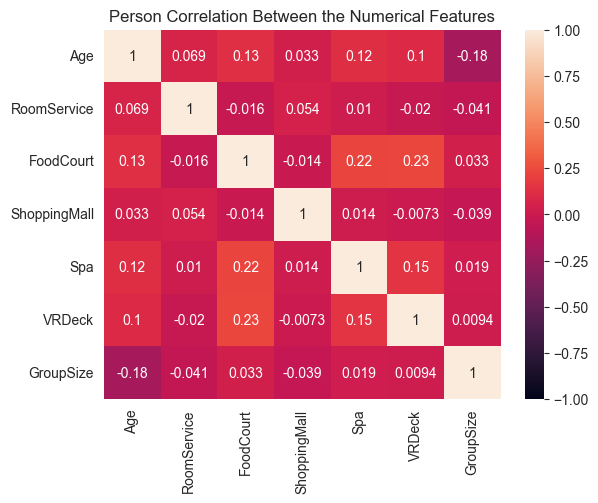

In [21]:
corr = spaceship_eda.select_dtypes(include="number").corr()
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title("Person Correlation Between the Numerical Features")
plt.show()

In [ ]:
corr = spaceship_eda.replace(
    {"No": 0, "Yes": 1, "Male": 1, "Female": 0, "Urban": 1, "Rural": 0}
)[
    [
        "hypertension",
        "heart_disease",
        "ever_married",
        "gender",
        "Residence_type",
        "stroke",
    ]
].corr(
    "spearman"
)
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap=fun.figure_colors_cmap)
plt.title("Spearman Correlation Between the Yes/No Features")
plt.show()

## 3.1. Distribution

In [13]:
target_name = 'Transported'
data, target = (spaceship_eda.drop(columns=[target_name]), 
                spaceship_eda[target_name])

Drop columns PassengerId, Cabin, Group, and Num as they have a large amount of 
unqiue values, not suitable for visualization.

In [14]:
categorical_columns_selector = selector(dtype_exclude='float64')
numerical_columns_selector = selector(dtype_include='float64')

categorical_columns = categorical_columns_selector(data)
categorical_columns.remove('PassengerId')
categorical_columns.remove('Cabin')
categorical_columns.remove('Group')
categorical_columns.remove('Num')
numerical_columns = numerical_columns_selector(data)

**Numerical Features**

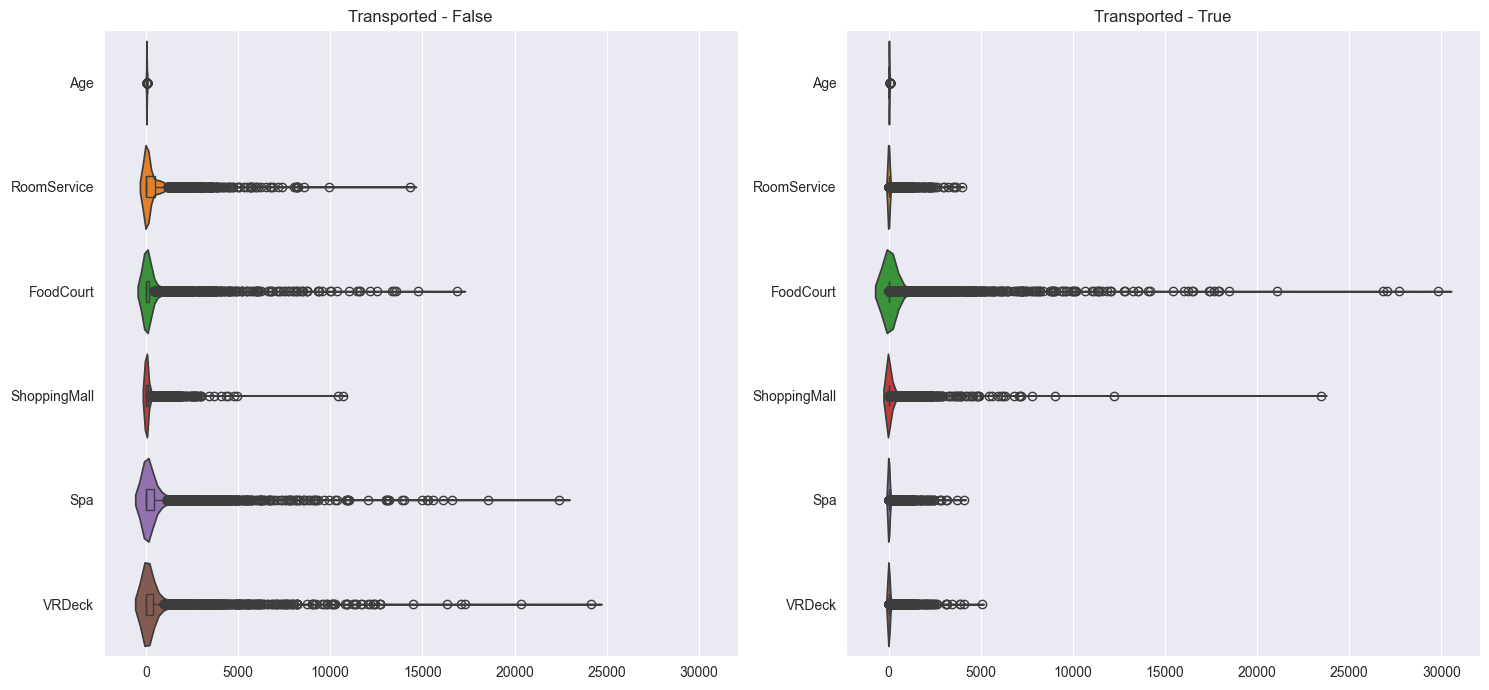

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharex=True)

violin_boxplot(data=spaceship_eda[spaceship_eda.Transported == True], 
               columns=numerical_columns, title='Transported - True', 
               ax=axes[1])
violin_boxplot(data=spaceship_eda[spaceship_eda.Transported == False], 
               columns=numerical_columns, title='Transported - False', 
               ax=axes[0])

plt.tight_layout()
plt.show()

Taking a closer look at the plots.

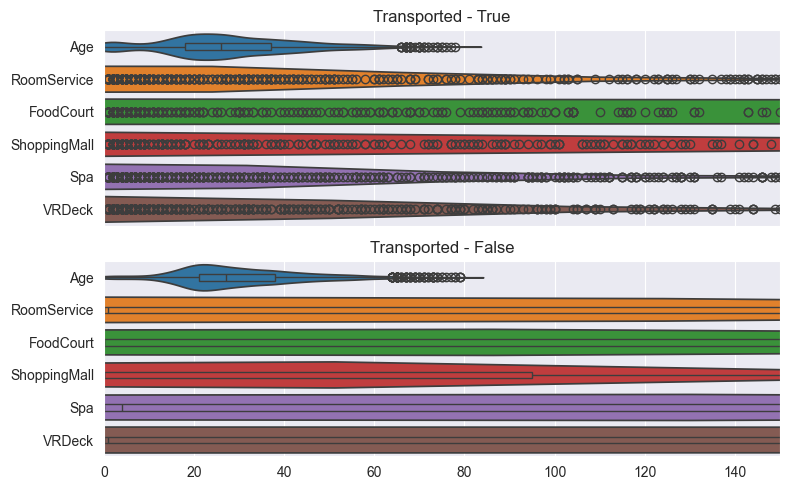

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)

violin_boxplot(data=spaceship_eda[spaceship_eda.Transported == True], 
               columns=numerical_columns, title='Transported - True', 
               ax=axes[0])
violin_boxplot(data=spaceship_eda[spaceship_eda.Transported == False], 
               columns=numerical_columns, title='Transported - False', 
               ax=axes[1])

axes[1].set_xlim(0, 150)
axes[0].set_xlim(0, 150)
plt.tight_layout()
plt.show()

In [17]:
spaceship_eda[spaceship_eda.Transported==True].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize
count,4288.000000,4295.000000,4279.000000,4264.000000,4287.000000,4280.000000,4378.000000
mean,27.748834,63.098021,532.691984,179.829972,61.675531,69.148131,2.166514
std,15.151705,274.812497,1931.306995,722.026714,262.682871,291.658171,1.616655
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,78.000000,3992.000000,29813.000000,23492.000000,4103.000000,5063.000000,8.000000


In [18]:
spaceship_eda[spaceship_eda.Transported==False].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize
count,4226.000000,4217.000000,4231.000000,4221.000000,4223.000000,4225.000000,4315.000000
mean,29.922858,389.266066,382.615930,167.566217,564.382666,543.629822,1.902665
std,13.699262,875.638123,1200.115601,456.528126,1551.356047,1563.088368,1.564494
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,27.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000
75%,38.000000,473.000000,179.000000,95.000000,453.500000,388.000000,2.000000
max,79.000000,14327.000000,16856.000000,10705.000000,22408.000000,24133.000000,8.000000


Notice all luxury amenities spending features display median 
values close to 0. When taken into account the whole IQR, people who were NOT 
 transported, had higher amenities spending.

**Categorical Features - without PassengerID, Name, Cabin**

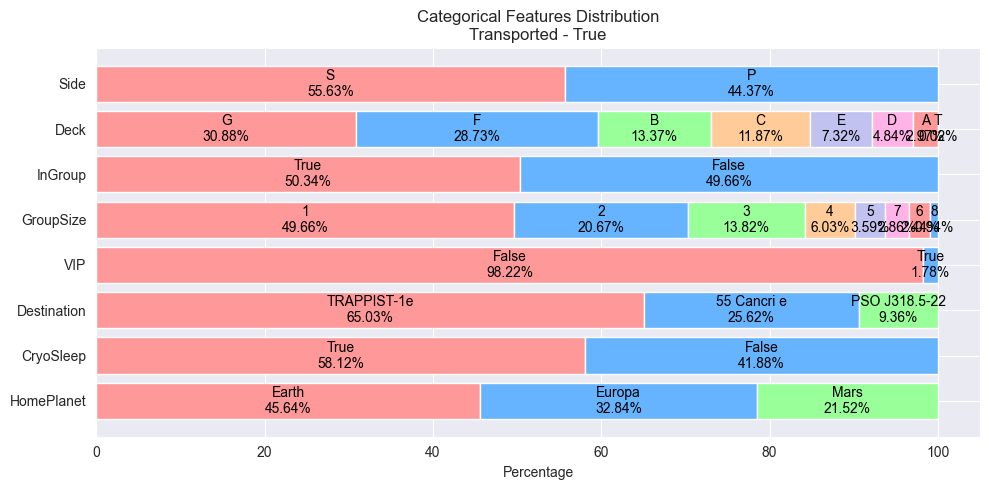

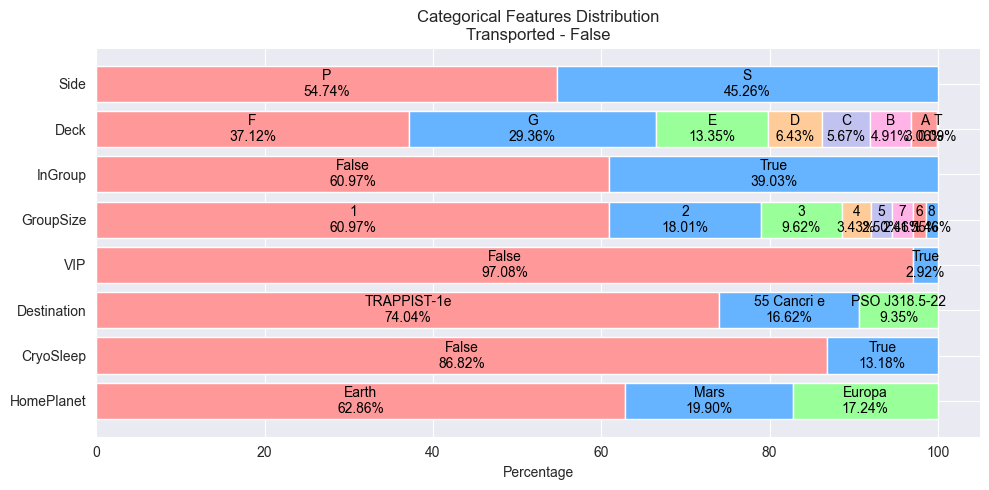

In [19]:
stacked_horizontal_feature_distribution(
    data=spaceship_eda[spaceship_eda.Transported == True], 
    columns=categorical_columns, 
    title='Categorical Features Distribution\nTransported - True') 

stacked_horizontal_feature_distribution(
    data=spaceship_eda[spaceship_eda.Transported == False], 
    columns=categorical_columns,
    title='Categorical Features Distribution\nTransported - False')

The distributions in general are coherent with what was observed at section 
2, Initial Data Cleaning.<br> 
There are some differences between the target labels, mainly at the 
numerical features, and in the features 'CyroSleep'. <br>
Also, some more subtle differences from other features.

## 3.2 Correlation

correlation:
pearsons correlation within numerical features
spearmans correlation within True/False features (multi category features?)
VIF (multicollinearity)

correlation feature vs target:
spearmans (univariate)
mutual information (univariate)
boruta (multivariate)


statistical inference:
chi-square/ t test with features vs target
any other special finds from correlation

1. extract information from 'PassengerId' (how many passengers in the groups)
2. extract from 'cabin' (3 features - deck, num, side)